# __[ 패스트캠퍼스] Density-based Methods__

# <br>__1. Data: NASA Bearing Dataset__

- 데이터 description <br>
    - NASA Bearing Dataset은 NSF I/UCR Center의 Intelligent Maintenance System의 4개의 bearing에서 고장이 발생할 때까지 10분 단위로 수집된 센서 데이터이다. 본 데이터셋은 특정 구간에서 기록된 1-second vibration signal snapshots을 나타내는 여러 개의 파일로 구성되어 있다. 각 파일은 20 kHz 단위로 샘플링 된 20,480개의 data point를 포함하고 있으며, 각 파일의 이름은 데이터가 수집된 시간을 의미한다. 해당 데이터셋은 크게 3개의 데이터를 포함하고 있으며, 본 실습에서 사용하는 데이터는 bearing 1에서 outer race failure가 발생할 때까지 수집된 센서 데이터이다. <br><br>
- 변수 설명
    - 독립 변수 (4개): Bearing1, Bearing2, Bearing3, Bearing4 <br><br>
- 출처: https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/


<img src="https://i.imgur.com/dfFzn3H.jpg" width="600">

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Step1. 데이터 병합

In [3]:
# 데이터 로드 및 병합
# './data/raw_data' 폴더에 있는 txt 파일 각각에 대하여 순차적으로 파일을 불러온 후, 변수별 절댓값 평균을 축적하여 데이터를 구축
data_root_dir = '../data/anomaly/raw_data'
merged_data = pd.DataFrame()

for filename in os.listdir(data_root_dir):
    # 데이터 불러오기
    data = pd.read_csv(os.path.join(data_root_dir, filename), sep='\t')
    
    # 변수별 절댓값 평균 계산
    data_mean_abs = np.array(data.abs().mean())
    data_mean_abs = pd.DataFrame(data_mean_abs.reshape(1,4))
    data_mean_abs.index = [filename]
    
    # 데이터 축적 -> 한 개의 txt 파일에 대하여 4개의 변수 값을 도출
    merged_data = pd.concat([merged_data, data_mean_abs])

In [4]:
# merged data index 및 column 설정
merged_data.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


In [5]:
# 데이터 불러오기
merged_data = pd.read_csv('../data/anomaly/merged_dataset.csv', index_col=0)
merged_data.index = pd.to_datetime(merged_data.index)
merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4,anomaly,data_type
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067,False,train
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541,False,train
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443,False,train
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081,False,train
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118,False,train


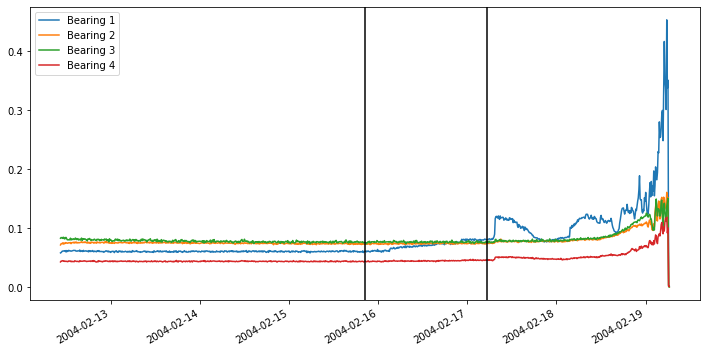

In [6]:
# 전체 기간의 데이터 분포 확인
merged_data.plot(figsize = (12, 6))
plt.axvline(merged_data.index[int(len(merged_data) * 0.5)], c='black')
plt.axvline(merged_data.index[int(len(merged_data) * 0.7)], c='black')

In [7]:
# normal/abnormal labeling
# 모델의 성능을 평가하기 위해 데이터 분포의 변화가 큰 후반부 30%를 고장으로 labeling
num_normal = int(len(merged_data) * 0.7)
num_abnormal = len(merged_data) - num_normal

merged_data['anomaly'] = [False] * num_normal + [True] * num_abnormal

In [8]:
merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4,anomaly,data_type
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067,False,train
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541,False,train
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443,False,train
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081,False,train
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118,False,train


### Step2. 데이터 Split

In [9]:
# train 및 test 데이터 분리
# 데이터의 전반부 50%를 train 데이터로 사용
num_train = int(len(merged_data) * 0.5)
num_test = len(merged_data) - num_train

merged_data['data_type'] = ['train'] * num_train + ['test'] * num_test

In [10]:
merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4,anomaly,data_type
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067,False,train
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541,False,train
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443,False,train
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081,False,train
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118,False,train


In [11]:
# 데이터 저장
merged_data.to_csv('../data/anomaly/merged_dataset.csv')

In [12]:
X_train = merged_data[merged_data['data_type'] == 'train'].iloc[:, :4]
y_train = merged_data[merged_data['data_type'] == 'train'].iloc[:, -2].values

X_test = merged_data[merged_data['data_type'] == 'test'].iloc[:, :4]
y_test = merged_data[merged_data['data_type'] == 'test'].iloc[:, -2].values

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (492, 4)
Test data shape: (492, 4)


---

# __<br> 2. 밀도 기반 이상치 탐지 기법: Gauss & MoG & Parzen Window__

## 밀도 기반 이상치 탐지 기법의 목적
>주어진 데이터를 바탕으로 각 객체들이 생성될 확률을 추정 <br>
>새로운 데이터가 생성될 확률이 낮을 경우 이상치로 판단

<img src="https://i.imgur.com/e9omVxY.jpg" width="800">

# __2-1. Gaussian Density Estimation__

### Gaussian Density Estimation
>모든 데이터가 하나의 가우시안(정규) 분포로부터 생성됨을 가정 <br>
>학습: 주어진 정상 데이터들을 통해 가우시안 분포의 평균 벡터와 공분산 행렬을 추정 <br>
>테스트: 새로운 데이터에 대하여 생성 확률을 구하고 이 확률이 낮을수록 이상치에 가까운 것으로 판정함

In [13]:
import math
import seaborn as sns
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

### Step 1. Train 데이터 기반 분포 추정

In [14]:
# 가우시안 분포 추정 함수
def estimate_gaussian(dataset):
    mu = np.mean(dataset, axis=0).values
    sigma = np.cov(dataset.T)
    return mu, sigma

In [15]:
mu, sigma = estimate_gaussian(X_train)

print('Dimension of mu:', mu.shape)
print('Dimension of sigma:', sigma.shape)

Dimension of mu: (4,)
Dimension of sigma: (4, 4)


### Step 2. 추정된 분포를 기반으로 train/test 데이터의 anomaly score 도출

In [16]:
# 다변량 가우시안 분포에서 -logpdf를 반환하는 함수
def multivariate_gaussian(dataset, mu, sigma):
    p = multivariate_normal(mean=mu, cov=sigma)
    return - 1.0 * p.logpdf(dataset)

In [17]:
# train/test 데이터의 -logpdf 값 도출
gauss_train = multivariate_gaussian(X_train, mu, sigma)
gauss_test = multivariate_gaussian(X_test, mu, sigma)

Text(0.5, 1.0, 'Test Data')

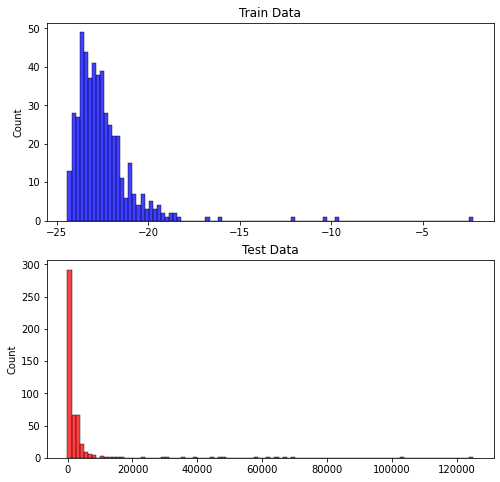

In [21]:
# train/test 데이터의 anomaly score 분포 시각화
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (8, 8))

sns.histplot(gauss_train, bins=100, color='blue', ax=ax1)
sns.histplot(gauss_test, bins=100, color='red', ax=ax2)
ax1.set_title("Train Data")
ax2.set_title("Test Data")

### Step 3. Threshold 탐색

In [22]:
# threshold 탐색
# score의 min ~ max 범위를 num_step개로 균등 분할한 threshold에 대하여 best threshold 탐색 
def search_best_threshold(score, y_true, num_step):
    best_f1 = 0.5
    best_threshold = None
    for threshold in np.linspace(min(score), max(score), num_step):
        y_pred = threshold < score

        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    print('Best threshold: ', round(best_threshold, 4))
    print('Best F1 Score:', round(best_f1, 4))
    return best_threshold

In [23]:
# best threshold 도출
gauss_best_threshold = search_best_threshold(gauss_test, y_test, num_step=1000)

Best threshold:  226.5447
Best F1 Score: 0.925


### Step 4. Best threshold를 기반으로 이상치 탐지 모형 평가

In [24]:
# 최종 결과 도출
gauss_scores = pd.DataFrame(index=merged_data.index)
gauss_scores['score'] = list(np.hstack([gauss_train, gauss_test]))
gauss_scores['anomaly'] = gauss_best_threshold < gauss_scores['score']
gauss_scores.head()

,score,anomaly
2004-02-12 10:32:39,-2.232404,False
2004-02-12 10:42:39,-10.370993,False
2004-02-12 10:52:39,-16.055669,False
2004-02-12 11:02:39,-12.009868,False
2004-02-12 11:12:39,-20.159965,False


In [25]:
# anomaly score plot 도출
def draw_plot(scores, threshold):
    normal_scores = scores[scores['anomaly'] == False]
    abnormal_scores = scores[scores['anomaly'] == True]

    plt.figure(figsize = (12,5))
    plt.scatter(normal_scores.index, normal_scores['score'], label='Normal', c='blue', s=3)
    plt.scatter(abnormal_scores.index, abnormal_scores['score'], label='Abnormal', c='red', s=3)
    
    plt.axhline(threshold, c='green', alpha=0.7)
    plt.axvline(merged_data.index[int(len(merged_data) * 0.5)], c='orange', ls='--')

    plt.xlabel('Date')
    plt.ylabel('Anomaly Score')
    plt.legend()
    
    plt.show()

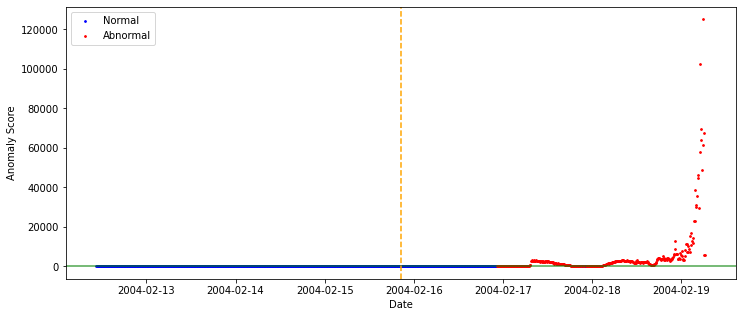

In [26]:
# 전체 데이터의 anomaly score 확인
draw_plot(gauss_scores, gauss_best_threshold)

In [27]:
# FRR, FAR, F1 score 도출
def calculate_metric(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[True, False])
    tp, fn, fp, tn = cm.ravel()
    
    frr = fp / (fp + tn)
    far = fn / (fn + tp) 
    
    f1 = f1_score(y_true, y_pred)
    
    return frr, far, f1

In [28]:
# F1 Score: 0.9250
frr, far, f1 = calculate_metric(y_test, gauss_scores['anomaly'].iloc[int(len(merged_data) * 0.5):])

print("**  FRR: {}  |  FAR: {}  |  F1 Score: {}".format(round(frr, 4), round(far, 4), round(f1, 4)))

**  FRR: 0.2092  |  FAR: 0.0203  |  F1 Score: 0.925


---

# __<br> 2-2. Mixture of Gaussian (MoG) Density Estimation__

### Mixture of Gaussian (MoG) Density Estimation
>데이터가 **여러 개의 가우시안(정규) 분포의 혼합**으로 이루어져 있음을 허용하며, 여러 가우시안 분포들의 선형 결합으로 전체 데이터의 분포를 표현 <br>
>학습: 주어진 정상 데이터들을 통해 여러 가우시안 분포의 평균 벡터와 공분산 행렬 및 선형 가중치를 추정 <br>
>테스트: 새로운 데이터에 대하여 생성 확률을 구하고 이 확률이 낮을수록 이상치에 가까운 것으로 판정함

In [29]:
from sklearn import mixture

### Step 1. Train 데이터 기반 분포 추정

- GaussianMixture 설명
    - n_components: 가우시안 분포 개수. 디폴트 1
    - covariance_type: 공분산 유형 ('full', 'tied', 'diag', 'spherical'). 디폴트 'full'
    - max_iter: EM 알고리즘 수행 횟수. 디폴트 100

In [30]:
gm_model = mixture.GaussianMixture(n_components=3, random_state=42)
gm_model.fit(X_train)

GaussianMixture(n_components=3, random_state=42)

In [31]:
# 추정된 혼합 가우시안 분포를 구성하는 각 가우시안 분포의 평균
gm_model.means_

array([[0.06096392, 0.07524499, 0.08090746, 0.04416265],
       [0.0607431 , 0.07468003, 0.07765362, 0.04398523],
       [0.06086029, 0.07500918, 0.07853607, 0.04404562]])

In [32]:
# 추정된 혼합 가우시안 분포를 구성하는 각 가우시안 분포의 공분산
gm_model.covariances_

array([[[ 1.93510930e-06,  4.58040923e-07,  4.83511719e-08,
          1.76149019e-07],
        [ 4.58040923e-07,  2.17586417e-06, -2.57499558e-07,
          1.29916390e-07],
        [ 4.83511719e-08, -2.57499558e-07,  6.13709347e-06,
          2.18104112e-07],
        [ 1.76149019e-07,  1.29916390e-07,  2.18104112e-07,
          1.28266105e-06]],

       [[ 1.58799572e-06,  1.81577457e-07,  2.71829042e-07,
          1.07930755e-07],
        [ 1.81577457e-07,  1.88551785e-06,  9.36420426e-07,
          1.21736642e-07],
        [ 2.71829042e-07,  9.36420426e-07,  3.57407575e-06,
          1.47444415e-07],
        [ 1.07930755e-07,  1.21736642e-07,  1.47444415e-07,
          1.24807256e-06]],

       [[ 1.63314512e-06,  2.33986902e-07,  4.94140832e-07,
          1.24443192e-07],
        [ 2.33986902e-07,  1.96329795e-06,  1.30323113e-06,
          1.40391843e-07],
        [ 4.94140832e-07,  1.30323113e-06,  5.01086703e-06,
          2.33312285e-07],
        [ 1.24443192e-07,  1.40391843e-

In [33]:
# 추정된 혼합 가우시안 분포를 구성하는 각 가우시안 분포의 가중치
gm_model.weights_

array([0.07291664, 0.39781819, 0.52926516])

### Step 2. 추정된 분포를 기반으로 train/test 데이터의 anomaly score 도출

In [34]:
# train/test 데이터의 -logpdf 도출
gm_train = - 1.0 * gm_model.score_samples(X_train)
gm_test = - 1.0 * gm_model.score_samples(X_test)

Text(0.5, 1.0, 'Test Data')

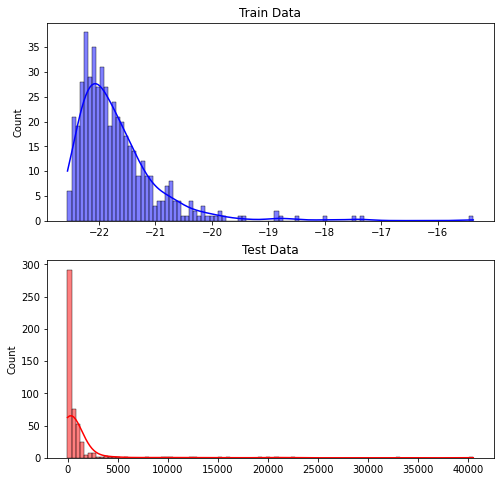

In [35]:
# train/test 데이터의 anomaly score 분포 시각화
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (8, 8))

sns.histplot(gm_train, bins=100, kde=True, color='blue', ax=ax1)
sns.histplot(gm_test, bins=100, kde=True, color='red', ax=ax2)
ax1.set_title("Train Data")
ax2.set_title("Test Data")

### Step 3. Threshold 탐색

In [36]:
# best threshold 도출
gm_best_threshold = search_best_threshold(gm_test, y_test, num_step=1000)

Best threshold:  58.7878
Best F1 Score: 0.9268


### Step 4. Best threshold를 기반으로 이상치 탐지 모형 평가

In [37]:
# 최종 결과 도출
gm_scores = pd.DataFrame(index=merged_data.index)
gm_scores['score'] = list(np.hstack([gm_train, gm_test]))
gm_scores['anomaly'] = gm_best_threshold < gm_scores['score']
gm_scores.head()

,score,anomaly
2004-02-12 10:32:39,-15.368591,False
2004-02-12 10:42:39,-17.475524,False
2004-02-12 10:52:39,-18.824166,False
2004-02-12 11:02:39,-17.964283,False
2004-02-12 11:12:39,-20.166698,False


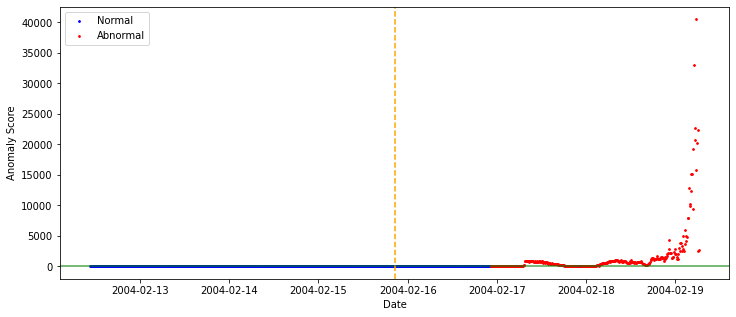

In [38]:
# 전체 데이터의 anomaly score 확인
draw_plot(gm_scores, gm_best_threshold)

In [39]:
# F1 Score: 0.9268
frr, far, f1 = calculate_metric(y_test, gm_scores['anomaly'].iloc[int(len(merged_data) * 0.5):])

print("**  FRR: {}  |  FAR: {}  |  F1 Score: {}".format(round(frr, 4), round(far, 4), round(f1, 4)))

**  FRR: 0.2092  |  FAR: 0.0169  |  F1 Score: 0.9268


---

# __<br> 2-3. Parzen Window__

### Kernel Density Estimation (Parzen Window)
>데이터가 특정한 분포를 갖는다는 가정없이 주어진 데이터로부터 주변부의 밀도를 추정하는 방식

In [40]:
from sklearn.neighbors import KernelDensity

### Step 1. Train 데이터 기반 분포 추정

- KernelDensity 설명
    - kernel: 사용할 커널 종류 ('gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine'). 디폴트 'gaussian'

In [41]:
kde_model = KernelDensity(kernel='gaussian', bandwidth=0.2)
kde_model.fit(X_train)

KernelDensity(bandwidth=0.2)

### Step 2. 추정된 분포를 기반으로 train/test 데이터의 anomaly score 도출

In [42]:
# train/test 데이터의 -logpdf 도출
kde_train = - 1.0 * kde_model.score_samples(X_train)
kde_test = - 1.0 * kde_model.score_samples(X_test)

In [43]:
kde_train

array([-2.76141686, -2.76140485, -2.76152183, -2.76142368, -2.76164582,
       -2.76134797, -2.7616718 , -2.76174446, -2.76143151, -2.76143743,
       -2.76169826, -2.76185811, -2.76184345, -2.76180793, -2.76183366,
       -2.76181867, -2.76158304, -2.76186517, -2.76176856, -2.76177046,
       -2.76180336, -2.76165762, -2.76173182, -2.76174023, -2.76150692,
       -2.76169594, -2.761798  , -2.76173166, -2.76168918, -2.76184834,
       -2.76178439, -2.7617193 , -2.76186599, -2.76169554, -2.76152065,
       -2.76189243, -2.76171056, -2.76172669, -2.7617081 , -2.7617229 ,
       -2.76168764, -2.76180229, -2.76189257, -2.76191472, -2.76172422,
       -2.76180691, -2.76169252, -2.7616756 , -2.76177124, -2.7619033 ,
       -2.76178355, -2.76184648, -2.76183301, -2.76184501, -2.7618081 ,
       -2.76175604, -2.76186026, -2.76189335, -2.76188882, -2.76172735,
       -2.76180633, -2.7617901 , -2.76176436, -2.76188524, -2.76185049,
       -2.76189287, -2.76178678, -2.76184193, -2.76182831, -2.76

Text(0.5, 1.0, 'Test Data')

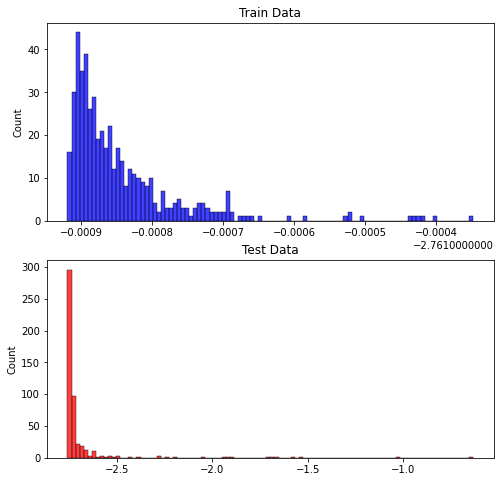

In [46]:
# train/test 데이터의 anomaly score 분포 시각화
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (8, 8))

sns.histplot(kde_train, bins=100, color='blue', ax=ax1)
sns.histplot(kde_test, bins=100, color='red', ax=ax2)
ax1.set_title("Train Data")
ax2.set_title("Test Data")

### Step 3. Threshold 탐색

In [47]:
# best threshold 탐색
kde_best_threshold = search_best_threshold(kde_test, y_test, num_step=1000)

Best threshold:  -2.7576
Best F1 Score: 0.929


### Step 4. Best threshold를 기반으로 이상치 탐지 모형 평가

In [48]:
# 최종 결과 도출
kde_scores = pd.DataFrame(index=merged_data.index)
kde_scores['score'] = list(np.hstack([kde_train, kde_test]))
kde_scores['anomaly'] = kde_best_threshold < kde_scores['score']
kde_scores.head()

,score,anomaly
2004-02-12 10:32:39,-2.761417,False
2004-02-12 10:42:39,-2.761405,False
2004-02-12 10:52:39,-2.761522,False
2004-02-12 11:02:39,-2.761424,False
2004-02-12 11:12:39,-2.761646,False


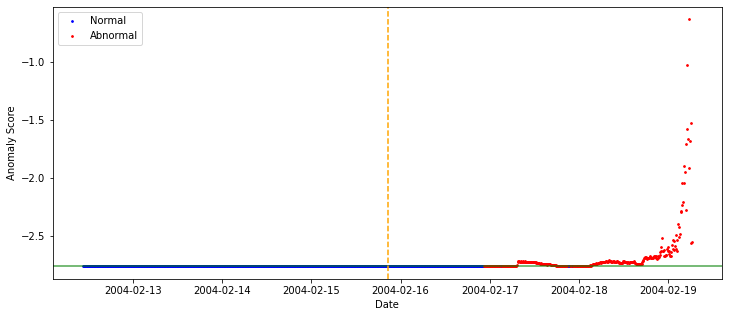

In [49]:
# 전체 데이터의 anomaly score 확인
draw_plot(kde_scores, kde_best_threshold)

In [51]:
# F1 Score: 0.9290
frr, far, f1 = calculate_metric(y_test, kde_scores['anomaly'].iloc[int(len(merged_data) * 0.5):])

print("**  FRR: {}  |  FAR: {}  |  F1 Score: {}".format(round(frr, 4), round(far, 4), round(f1, 4)))

**  FRR: 0.1837  |  FAR: 0.027  |  F1 Score: 0.929


---